# Project 2: Traffic Sign Classifier

## Kemal Tepe, ketepe@gmail.com

In [1]:
# setup important imports and libs 
import pickle
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

In [2]:
# debug printing sections, 1 if they need printing
debug_prt=1
image_show=1
%matplotlib inline

In [3]:
#utility function from RGB to Grayscale
#
def rgb2gray(input_data):
    #below is weigths of RGB to Gray conversion from the literature
    rgbmix=[0.3, 0.585, 0.115]
    #
    #below is equal weigths but above did worked better
    #rgbmix=[0.333, 0.333, 0.334]
    for i in range(len(input_data)):
        image2=input_data[i,:,:,:]
        input_data[i,:,:,0]=np.dot(image2[...,:3], rgbmix)

    return input_data[:,:,:,0:1]

#utilitity function Softmax
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()



In [4]:
#my convolutional NN architecture. 
#it is derived from Lenet 5 architecture, 
#but optimized by using number of hidden nodes for the traffic sign clasification 
#
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.03 # hyperparameter for noise
    #set up the number of nodes between the layers
    w1nodes=48 # number of conv hidden nodes in the conv NN in the layer 1
    w2nodes=96 # number of conv hidden nodes in the conv NN in the layer 2 
    w3nodes=5*5*w2nodes #number of fully connected nodes in layer 3 and flattening 
    w4nodes=140 #number of fully connected nodes in layer 4
    w5nodes=96 #number of fully connected nodes in Layer 5
    outputnodes=43 #number of output nodes, since there are 43 signs in the data set.
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x(w1nodes).
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, w1nodes), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(w1nodes))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    #instead of RELU, i used ELU non-linear function
    conv1 = tf.nn.elu(conv1)

    # SOLUTION: Pooling. Input = 28x28x(w1nodes). Output = 14x14x(w1nodes).
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x(w2nodes).
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, w1nodes, w2nodes), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(w2nodes))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.elu(conv2)

    # SOLUTION: Pooling. Input = 10x10x1(w2nodes) Output = 5x5x(w2nodes).
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x(w2nodes). Output = w3nodes.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = w3nodes Output = w4nodes
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(w3nodes, w4nodes), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(w4nodes))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.elu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = w4nodes Output = w5nodes

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(w4nodes, w5nodes), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(w5nodes))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.elu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = w5nodes Output = outputnodes.
    
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(w5nodes, outputnodes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(outputnodes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


In [5]:
#evaluation function
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [6]:
#Reading the training, validation and testing data 
#stored in the subfolder "traffic-signs-data" folder
training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
#Number of training examples
n_train = len(X_train)

#Number of testing examples.
n_test = len(X_test)

#the shape of an traffic sign image
image_shape = X_train[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = len(train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 4


image index 25 --image name-- Road work


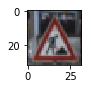

In [8]:
# Visualizations will be shown in the notebook.
index = random.randint(0, n_train)
image = X_train[index].squeeze()

signnames=pd.DataFrame(pd.read_csv("signnames.csv"))
#in order to show these, the switch values must be 1 in the first cell.
if debug_prt:
    print('image index', y_train[index], '--image name--', signnames.loc[y_train[index]]['SignName'])

if image_show:
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")

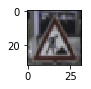

In [9]:
#RGB to Gray conversions
X_train=rgb2gray(X_train)
X_valid=rgb2gray(X_valid)
X_test=rgb2gray(X_test)
if image_show:
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    
#shuffle image so it will get different sequence for training     
X_train, y_train = shuffle(X_train, y_train)



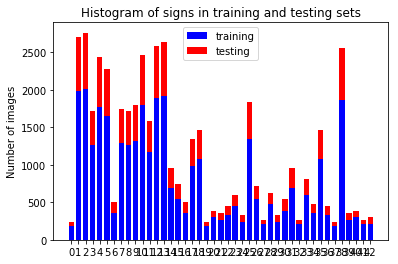

In [10]:
#data det analysis
n_signs=len(signnames)

count_train=np.zeros((n_signs,1))
count_test=np.zeros((n_signs,1))

for i in range(n_train):
    count_train[y_train[i]]+=1

for i in range(n_test):
    count_test[y_test[i]]+=1
    
width=0.75

p1 = plt.bar(range(n_signs), count_train, width, color='blue') 
p2 = plt.bar(range(n_signs), count_test, width, bottom=count_train, color='red')
plt.ylabel('Number of images')
plt.title('Histogram of signs in training and testing sets')
plt.xticks(range(n_signs))
plt.legend((p1[0], p2[0]), ('training', 'testing'))
plt.show()

In [11]:
# setup the training parameters
#original rate = 0.001 
rate=0.001
EPOCHS = 20
BATCH_SIZE = 128
print('learning rate', rate, 'Epoch', EPOCHS, 'Batch Size', BATCH_SIZE)

# setup tensors to be feed at each epoch
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,43)

### Train your model here.
#set up the system
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#Evaluate how well the loss and accuracy of the model for a given dataset.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()



learning rate 0.001 Epoch 20 Batch Size 128


In [12]:
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.897

EPOCH 2 ...
Validation Accuracy = 0.931

EPOCH 3 ...
Validation Accuracy = 0.955

EPOCH 4 ...
Validation Accuracy = 0.933

EPOCH 5 ...
Validation Accuracy = 0.942

EPOCH 6 ...
Validation Accuracy = 0.922

EPOCH 7 ...
Validation Accuracy = 0.956

EPOCH 8 ...
Validation Accuracy = 0.956

EPOCH 9 ...
Validation Accuracy = 0.954

EPOCH 10 ...
Validation Accuracy = 0.941

EPOCH 11 ...
Validation Accuracy = 0.937

EPOCH 12 ...
Validation Accuracy = 0.929

EPOCH 13 ...
Validation Accuracy = 0.942

EPOCH 14 ...
Validation Accuracy = 0.917

EPOCH 15 ...
Validation Accuracy = 0.947

EPOCH 16 ...
Validation Accuracy = 0.953

EPOCH 17 ...
Validation Accuracy = 0.945

EPOCH 18 ...
Validation Accuracy = 0.940

EPOCH 19 ...
Validation Accuracy = 0.946

EPOCH 20 ...
Validation Accuracy = 0.944

Model saved


In [13]:
#test accucary

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.938


In [14]:
#internet road signs
import matplotlib.image as mpimg

image0 = mpimg.imread('roadsigns/noentry_32.jpg')
image1 = mpimg.imread('roadsigns/nopedestrian_32.jpg')
image2 = mpimg.imread('roadsigns/speedlimit30_32.jpg')
image3 = mpimg.imread('roadsigns/stop_32.jpg')
image4 = mpimg.imread('roadsigns/yield_32.jpg')
image_labels=[17,27,1,14,13]

x_image=np.zeros((5,32,32,3))

x_image[0,:,:,:]=image0
x_image[1,:,:,:]=image1
x_image[2,:,:,:]=image2
x_image[3,:,:,:]=image3
x_image[4,:,:,:]=image4

x_image=rgb2gray(x_image)

#run with the trained session
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(x_image, image_labels)
    print("Internet Road Sign Accuracy = {:.3f}".format(test_accuracy))


Internet Road Sign Accuracy = 1.000


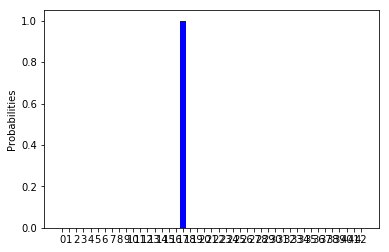

Probabilities and prediction from this 17 correct label 17


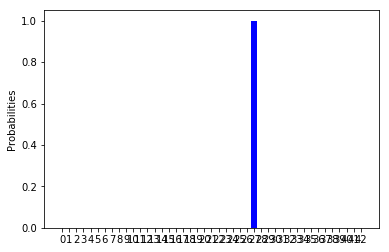

Probabilities and prediction from this 27 correct label 27


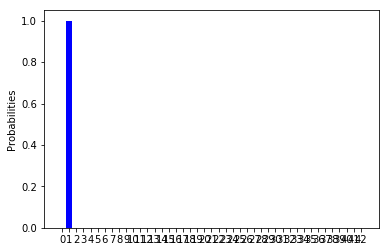

Probabilities and prediction from this 1 correct label 1


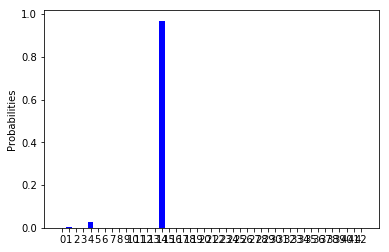

Probabilities and prediction from this 14 correct label 14


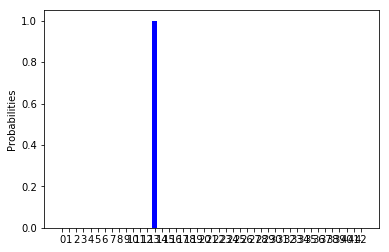

Probabilities and prediction from this 13 correct label 13


In [16]:
#investigation of the model with new images
def getpredict(X_data, y_data):
    sess = tf.get_default_session()
    predictions = sess.run(logits, feed_dict={x: X_data, y: y_data})
        
    return predictions


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicts = getpredict(x_image, image_labels)   

for i in range(len(predicts)):
    plt.figure(i)
    dummy=softmax(predicts[i,:])
    plt.bar(range(43), dummy, width=0.8, color='blue')
    plt.ylabel('Probabilities')
    plt.xticks(range(43))
    plt.show()
    print('Probabilities and prediction from this', dummy.argmax(), 'correct label', image_labels[i])
    